In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder,OneHotEncoder,OrdinalEncoder,MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Exploratory Data Analysis
### Attribute Information
1) ID: unique identifier
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9) Spiders: presence of spiders N (No) or Y (Yes)
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11) Bilirubin: serum bilirubin in [mg/dl]
12) Cholesterol: serum cholesterol in [mg/dl]
13) Albumin: albumin in [gm/dl]
14) Copper: urine copper in [ug/day]
15) Alk_Phos: alkaline phosphatase in [U/liter]
16) SGOT: SGOT in [U/ml]
17) Triglycerides: triglicerides in [mg/dl]
18) Platelets: platelets per cubic [ml/1000]
19) Prothrombin: prothrombin time in seconds [s]
20) Stage: histologic stage of disease (1, 2, 3, or 4)

In [62]:
df = pd.read_csv("cirrhosis.csv")
df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,C,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,C,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


In [63]:
# Remove duplicate data
df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)

In [64]:
# Remove identifier
df = df.drop(columns=['ID'])
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


ID merupakan identifier sehingga perlu didrop

In [65]:
# Check missing value
missingValue = df.isnull().sum()
missingValue

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

Banyak sekali missing value pada data, Tryglicerides mempunyai 136 missing values, atau sekitar 32.5% dari total data. Berhubung data ini merupakan data medical, jika saya imputasi 32% dari total data, maka akan terlalu banyak data sintetis. Sehingga lebih baik saya drop missing value untuk menjaga keaslian data dan keakuratan data.

In [66]:
# Drop missing value
df = df.dropna().reset_index(drop=True)
missingValue = df.isnull().sum()
print(missingValue)

df

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,1153,C,D-penicillamine,22347,F,N,Y,N,N,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2.0
272,994,C,Placebo,21294,F,N,N,N,N,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2.0
273,939,C,D-penicillamine,22767,F,N,N,N,N,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0
274,839,C,D-penicillamine,13879,F,N,N,N,N,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0


Tersisa 276 data dari yang awalnya 418 data

In [67]:
# Memisahkan Categorical dan Numerical
cat_cols = []
num_cols = []

for i in df.columns:
    # print(str(df[i].dtype))
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

Categorical: ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
Numeric: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


Semua kolom telah terbaca sesuai dengan jenisnya. Walaupun stage adalah data kategorikal, tetapi pada akhirnya akan diubah menjadi numerikal dengan encoding, maka stage sudah tepat berada pada kolom numeric.

In [68]:
# Univariate Analysis (mode)
for i in cat_cols:
    print(df[i].value_counts(),'\n')
print(df['Stage'].value_counts())

Status
C     147
D     111
CL     18
Name: count, dtype: int64 

Drug
Placebo            140
D-penicillamine    136
Name: count, dtype: int64 

Sex
F    242
M     34
Name: count, dtype: int64 

Ascites
N    257
Y     19
Name: count, dtype: int64 

Hepatomegaly
Y    142
N    134
Name: count, dtype: int64 

Spiders
N    196
Y     80
Name: count, dtype: int64 

Edema
N    234
S     25
Y     17
Name: count, dtype: int64 

Stage
3.0    111
4.0     94
2.0     59
1.0     12
Name: count, dtype: int64


Y label memiliki data yang cukup terpusat pada kelas 3 sejumlah 111 data, di satu sisi kelas 1 hanya memiliki 12 data. Hal ini nantinya bisa memicu fallacy of accuracy. Data yang imbalance seperti ini bisa dihandle dengan oversampling (SMOTE), tetapi pada dasarnya model yang saya gunakan (NIM genap: random forest dan XGBoost) sudah cukup tahan terhadap imbalance data.

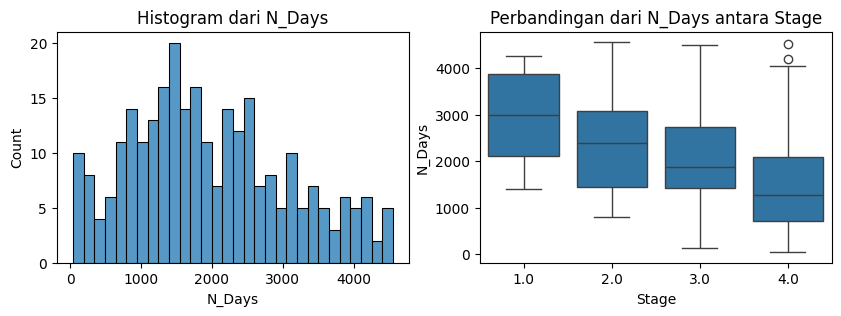

N_Days - Skewness: 0.40202283361594543
N_Days - Kurtosis: -0.5856459218862753


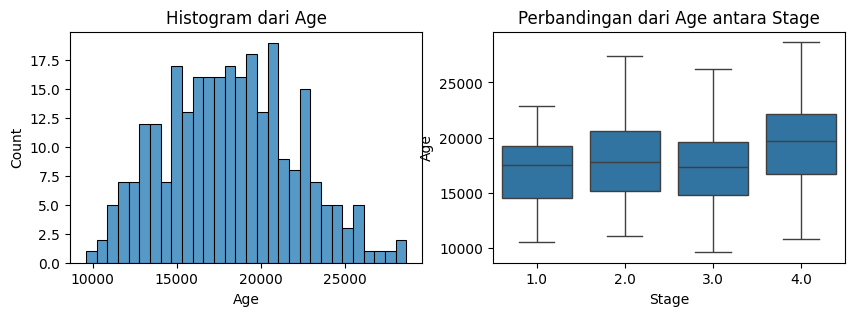

Age - Skewness: 0.18064548356599172
Age - Kurtosis: -0.48650213299338807


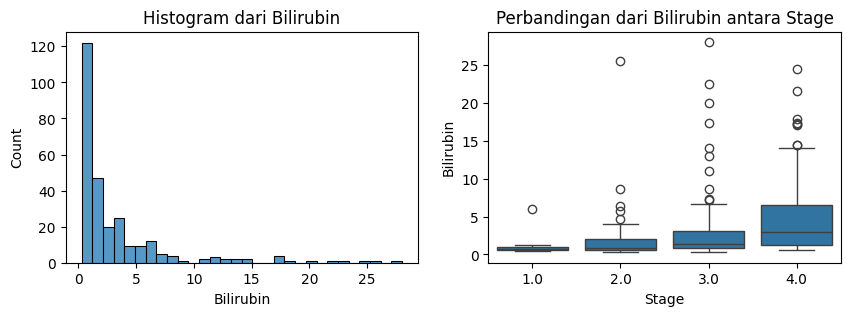

Bilirubin - Skewness: 2.8442672409908365
Bilirubin - Kurtosis: 8.891814794048443


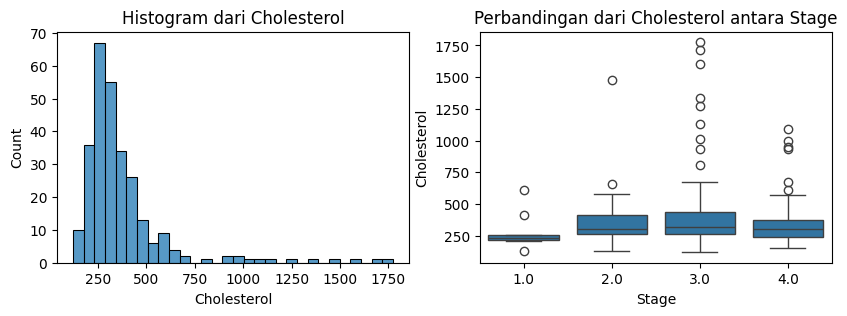

Cholesterol - Skewness: 3.3618806598133073
Cholesterol - Kurtosis: 13.899253928920169


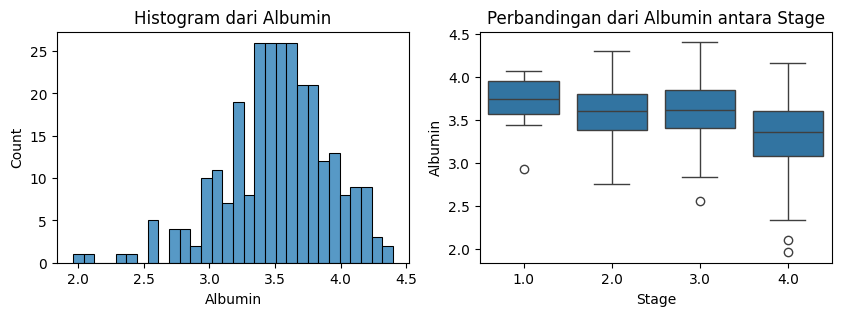

Albumin - Skewness: -0.597402801214279
Albumin - Kurtosis: 0.9089733786564205


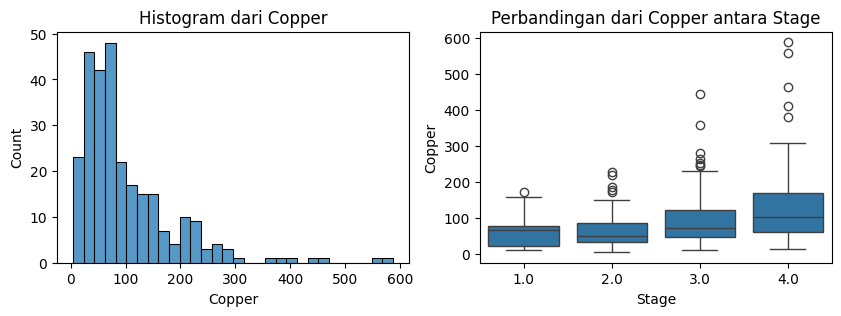

Copper - Skewness: 2.2663898962646702
Copper - Kurtosis: 7.203653535178681


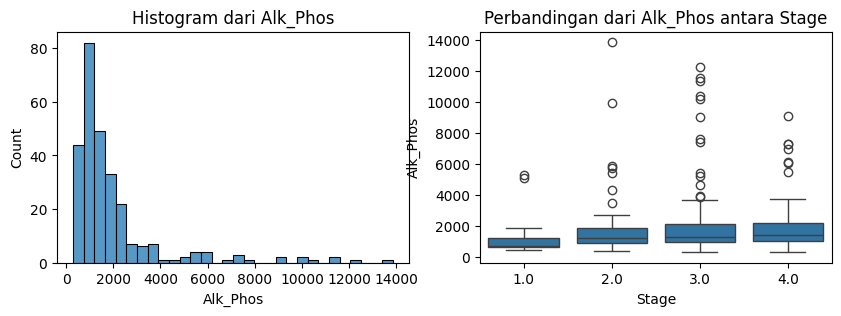

Alk_Phos - Skewness: 3.0350658642983115
Alk_Phos - Kurtosis: 10.191093309048023


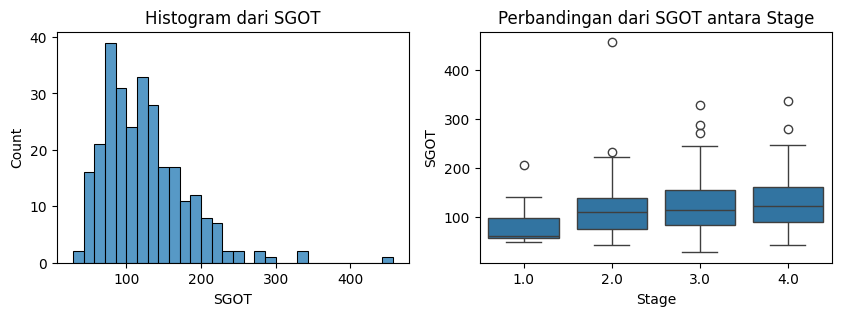

SGOT - Skewness: 1.4720920820130081
SGOT - Kurtosis: 4.594113070111765


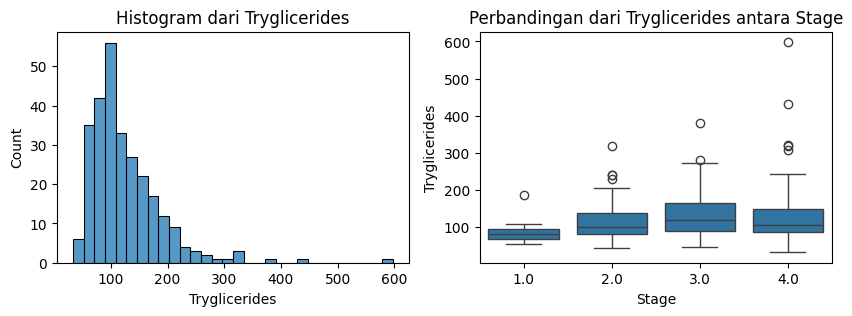

Tryglicerides - Skewness: 2.5413313394817894
Tryglicerides - Kurtosis: 11.933674756373412


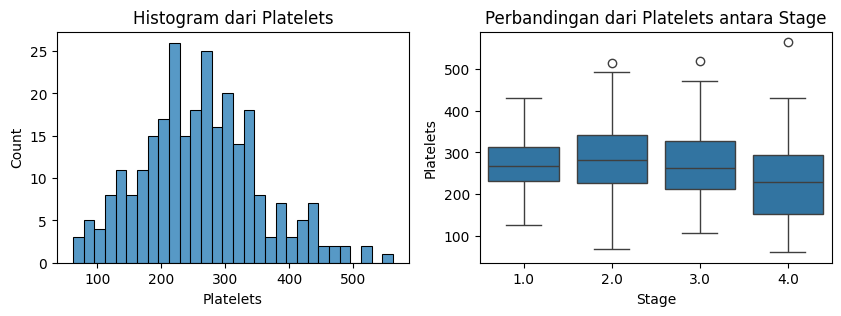

Platelets - Skewness: 0.37384331919126024
Platelets - Kurtosis: 0.08448680904026284


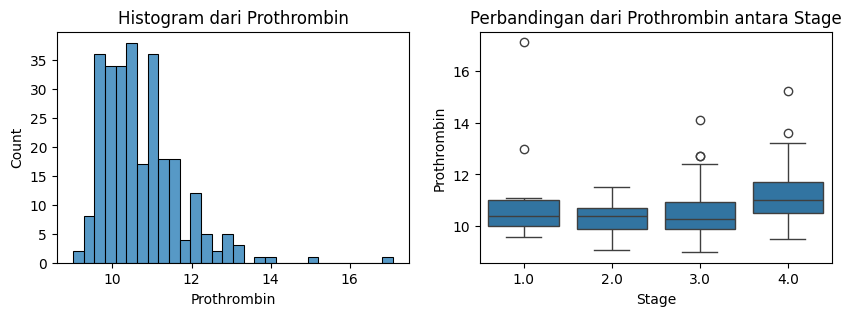

Prothrombin - Skewness: 1.8096118180936334
Prothrombin - Kurtosis: 6.606903249109067


In [69]:
# Check outlier and distribution
def check_distribution_outliers(dataframe, numerical):
    for col in numerical:
        if (col == 'Stage'): continue
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 2, 1)
        sns.histplot(dataframe[col], bins=30)
        plt.title(f'Histogram dari {col}')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x = 'Stage', y=col, data=dataframe)
        plt.title(f'Perbandingan dari {col} antara Stage')
        
        plt.show()

        print(f'{col} - Skewness: {dataframe[col].skew()}')
        print(f'{col} - Kurtosis: {dataframe[col].kurt()}')
        
check_distribution_outliers(df[num_cols], num_cols)

Dari boxplot di atas, dapat dilihat bahwa terdapat banyak outlier pada variabel seperti Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, dan Prothrombin. Namun, karena outlier sangat masuk akal dalam data medis seperti ini, outlier tidak akan dihilangkan atau dihapus, supaya model nantinya dapat menghandle pasien baru yang memiliki data seperti outlier.

Boxplot di atas memperlihatkan perbandingan value antara stage pada masing masing numerical column. Pada beberapa kolom, terlihat bahwa perbandingan antara stage berbanding lurus, seperti pada kolom N_Days, Bilirubin, Copper, dan SGOT. Namun, beberapa kolom tidak menunjukkan perbedaan yang linear antara stage, misalnya pada Cholesterol, Tryglicerides, dan Platelets. Kita dapat menggunakan Uji ANNOVA atau Kruskal untuk cek apakah terdapat perbedaan signifikan antara stage berbeda. Pertama-tama harus cek distribusi dahulu pada numerical column.

In [70]:
# check distribution
for i in num_cols:
    if (i == "Stage"): continue
    print(i, shapiro(df[i]))

N_Days ShapiroResult(statistic=np.float64(0.970696763576411), pvalue=np.float64(1.984682656593798e-05))
Age ShapiroResult(statistic=np.float64(0.9906980593157221), pvalue=np.float64(0.07685076772330962))
Bilirubin ShapiroResult(statistic=np.float64(0.6252453471754873), pvalue=np.float64(3.84319106730845e-24))
Cholesterol ShapiroResult(statistic=np.float64(0.6478328399199511), pvalue=np.float64(1.666301052445652e-23))
Albumin ShapiroResult(statistic=np.float64(0.9785032850656878), pvalue=np.float64(0.00035591674595920533))
Copper ShapiroResult(statistic=np.float64(0.7882723268131515), pvalue=np.float64(1.2434696325085965e-18))
Alk_Phos ShapiroResult(statistic=np.float64(0.6211441310238572), pvalue=np.float64(2.9663133270166822e-24))
SGOT ShapiroResult(statistic=np.float64(0.9107027438234933), pvalue=np.float64(9.447911481388115e-12))
Tryglicerides ShapiroResult(statistic=np.float64(0.8138718751877542), pvalue=np.float64(1.707596000087941e-17))
Platelets ShapiroResult(statistic=np.float6

Berdasarkan tes normalitas dari numerikal data menggunakan shapiro wilk, age memiliki p value = 0.0768, sehingga hanya age yang memiliki distribusi normal karena p value > 0.05. Maka Age dapat discaling menggunakan StandardScaler sedangkan sisanya menggunakan RobustScaler karena tidak berdistribusi normal.

Uji Annova juga akan dihindari karena numerical column tidak terdistribusi normal, kecuali Age. Maka kita akan menggunakan Uji Kruskal.

In [71]:
# Kruskal-Wallis untuk data tidak terdistribusi normal
h_statistic, p_value = stats.kruskal(df[df['Stage'] == 1]['Cholesterol'], 
                                      df[df['Stage'] == 2]['Cholesterol'],
                                      df[df['Stage'] == 3]['Cholesterol'],
                                      df[df['Stage'] == 4]['Cholesterol'])
print(f"Kruskal-Wallis Test: H-statistic = {h_statistic}, p-value = {p_value}")

Kruskal-Wallis Test: H-statistic = 13.29002884566467, p-value = 0.004049591299098289


In [72]:
# Kruskal-Wallis untuk data tidak terdistribusi normal
h_statistic, p_value = stats.kruskal(df[df['Stage'] == 1]['Tryglicerides'], 
                                      df[df['Stage'] == 2]['Tryglicerides'],
                                      df[df['Stage'] == 3]['Tryglicerides'],
                                      df[df['Stage'] == 4]['Tryglicerides'])
print(f"Kruskal-Wallis Test: H-statistic = {h_statistic}, p-value = {p_value}")

Kruskal-Wallis Test: H-statistic = 11.558391108207687, p-value = 0.009059691879069682


In [73]:
# Kruskal-Wallis untuk data tidak terdistribusi normal
h_statistic, p_value = stats.kruskal(df[df['Stage'] == 1]['Platelets'], 
                                      df[df['Stage'] == 2]['Platelets'],
                                      df[df['Stage'] == 3]['Platelets'],
                                      df[df['Stage'] == 4]['Platelets'])
print(f"Kruskal-Wallis Test: H-statistic = {h_statistic}, p-value = {p_value}")

Kruskal-Wallis Test: H-statistic = 17.26178857136225, p-value = 0.0006243101552991512


Dari tiga Uji Kruskal, semua p value memiliki nilai < 0.05 sehingga dapat disimpulkan bahwa ada perbedaan yang signifikan dalam distribusi kadar Cholesterol, Tryglicerides, dan Platelets antara kelas Stage yang berbeda. 

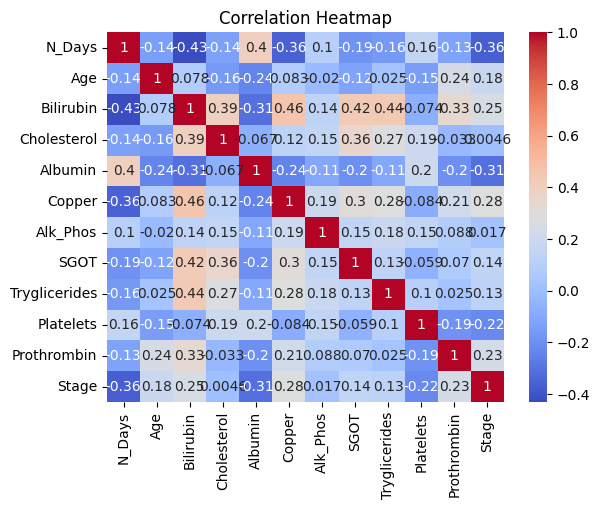

In [74]:
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Numerical variable yang paling berpengaruh pada stage adalah N_Days dan Albumin, keduanya berkorelasi negatif dengan stage, tetapi korelasinya tidak signifikan (lemah).

Status   C  CL   D
Stage             
1.0     11   0   1
2.0     42   3  14
3.0     62   8  41
4.0     32   7  55


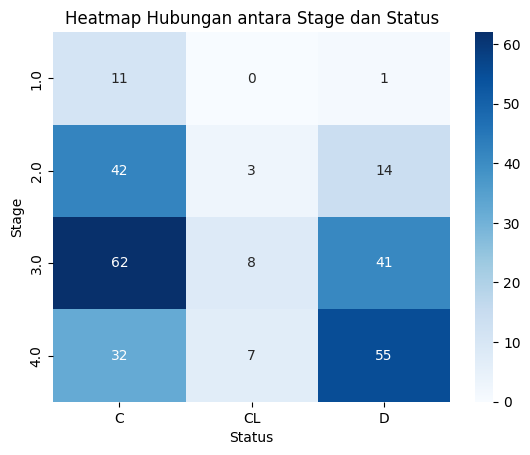

In [75]:
# Membuat tabel kontingensi antara Stage dan Status
contingency_table = pd.crosstab(df['Stage'], df['Status'])

# Menampilkan tabel kontingensi
print(contingency_table)

# Membuat heatmap untuk tabel kontingensi
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='d')

# Menambahkan judul
plt.title('Heatmap Hubungan antara Stage dan Status')
plt.show()

Karena penyakit Cirrhosis berkaitan dengan kematian, tabel di atas menunjukkan hubungan antara Status (Censored, Censored due to liver tx, and Death) dengan Stage. 49,55% dari data pasien yang meninggal merupakan pasien dengan stage 4 dan 58,51% dari data pasien dengan stage 4 merupakan pasien yang sudah meninggal dunia.

### EDA Summary
Berdasarkan hasil EDA, dari data di atas tidak ditemukan duplicate data, kalaupun ada sudah didrop/dihapus. Terdapat banyak missing value pada data, tetapi sudah didrop/dihapus untuk menjaga data supaya tidak banyak mengandung data sintetis, karena data yang digunakan merupakan data medis. Outlier pada data termasuk masuk akal sehingga tidak perlu dihandle supaya model mempelajari kasus nyata yang terjadi di dalam data. Y label pada data yakni Stage memiliki distribusi yang cukup terpusat pada stage 3 dengan perbandingan stage1:stage2:stage3:stage4 = 12:59:111:94. Hal ini perlu diperhatikan karena berpotensi menghasilkan model yang kurang mempelajari mengenai kelas stage 1. Selain itu, data memiliki 8 categorical column termasuk stage dan 11 numerical column. Dimana 10 numerical column tidak berdistribusi normal sehingga perlu menghindari analysis yang terkait dengan mean atau standar deviasi, kecuali pada kolom age karena age berdistribusi normal.

Untuk sifat pada tiap kelas di label y (stage), stage 1 adalah stage paling ringan dan stage 4 merupakan yang paling berat untuk penyakit cirrhosis, dari uji kruskal pada kolom Cholesterol, Tryglicerides, dan Platelets, terdapat perbedaan yang signifikan dalam distribusi antara kelas stage berbeda. 

## Preprocessing

#### Encoding
1. Status: bukan merupakan ordinal, maka menggunakan one hot encoder
2. Drug: D-penicillamine atau Placebo, sehingga cukup menggunakan label
3. Sex: Male atau Female, cukup menggunakan label
4. Ascites: N(No) atau Y(Yes), cukup menggunakan label
5. Hepatomegaly: N atau Y, cukup menggunakan label
6. Spiders: N atau Y, cukup menggunakan label
7. Edema: N, S atau Y, cukup menggunakan ordinal

In [76]:
lab_enc = LabelEncoder()

df = df.reset_index(drop=True)
df['Ascites'] = lab_enc.fit_transform(df['Ascites'].values)
df['Hepatomegaly'] = lab_enc.fit_transform(df['Hepatomegaly'].values)
df['Spiders'] = lab_enc.fit_transform(df['Spiders'].values)
df['Sex'] = lab_enc.fit_transform(df['Sex'].values)
df['Drug'] = lab_enc.fit_transform(df['Drug'].values)

In [77]:
ord_enc = OrdinalEncoder(categories=[['N','S','Y']])
df['Edema'] = ord_enc.fit_transform(df[['Edema']])

In [78]:
ohe_enc = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
df = pd.concat([df,ohe_enc.fit_transform(df[["Status"]])],axis=1)
df = df.drop(columns="Status")
df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,...,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status_C,Status_CL,Status_D
0,400,0,21464,0,1,1,1,2.0,14.5,261.0,...,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,0.0,0.0,1.0
1,4500,0,20617,0,0,1,1,0.0,1.1,302.0,...,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,1.0,0.0,0.0
2,1012,0,25594,1,0,0,0,1.0,1.4,176.0,...,210.0,516.0,96.10,55.0,151.0,12.0,4.0,0.0,0.0,1.0
3,1925,0,19994,0,0,1,1,1.0,1.8,244.0,...,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,0.0,0.0,1.0
4,1504,1,13918,0,0,1,1,0.0,3.4,279.0,...,143.0,671.0,113.15,72.0,136.0,10.9,3.0,0.0,1.0,0.0


In [79]:
# Spliting data
x = df[df.columns.drop(['Stage'])]
y = df['Stage']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)

Scaling Numerical Column, kecuali Age dengan RobustScaler karena tidak berdistribusi normal  
Age berdistribusi normal sehingga dapat scaling dengan StandardScaler

In [80]:
rob_scaler = RobustScaler()
std_scaler = StandardScaler()

num_cols.remove("Stage")
num_cols.remove("Age")

x_train[num_cols] = rob_scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = rob_scaler.transform(x_test[num_cols])

x_train["Age"] = std_scaler.fit_transform(x_train[["Age"]])
x_test["Age"] = std_scaler.transform(x_test[["Age"]])

## Train Model

### Random Forest

In [81]:
# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, max_leaf_nodes=16, n_jobs=-1, random_state=123)

# Train the model
rf_model.fit(x_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(x_test)

### Evaluate Random Forest Classifier

In [82]:
# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.5535714285714286
Confusion Matrix:
[[ 0  0  4  0]
 [ 0  1 10  0]
 [ 0  0 16  6]
 [ 0  0  5 14]]
Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       1.00      0.09      0.17        11
         3.0       0.46      0.73      0.56        22
         4.0       0.70      0.74      0.72        19

    accuracy                           0.55        56
   macro avg       0.54      0.39      0.36        56
weighted avg       0.61      0.55      0.50        56



c:\Users\hense\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hense\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hense\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Pada data ini, performance metrics yang paling penting adalah f1-score, karena False Negative serta False Positive sangat berpengaruh, kita tidak ingin seseorang didiagnosa dengan kelas penyakit yang lebih rendah dari seharusnya (false negative) dan juga seseorang didiagnosa dengan kelas penyakit yang lebih tinggi dari yang seharusnya (false positive). Model random forest di atas memiliki recall yang sangat buruk pada klasifikasi kelas 1 dan 2. Dimana tidak ada prediksi kelas 1 yang benar. Pada prediksi kelas 2, semua prediksi positifnya merupakan true positive (precision 1.00) tetapi hanya 0.09 atau 9% dari data actual positive yang diprediksi positif, artinya ada 91% data yang seharusnya kelas 2 tetapi tidak diprediksi kelas 2. Pada kelas 3, 46% dari prediksi positif oleh model merupakan actual positive, dan sebanyak 73% data actual positive berhasil diprediksi positif, artinya model memprediksi kelas 3 secara brutal, sehingga banyak recall tinggi, tetapi tidak presisi. Namun, pada kelas 4, model memiliki precision dan recall yang paling baik di antara kelas lain yakni precision 0.70, yakni 70% prediksi positif merupakan actual positive, dan recall 0.74 atau 74% data actual positive berhasil diprediksi positif.  

Secara keseluruhan, model memiliki precision sebesar 0.54 dan recall sebesar 0.39. Artinya, rata rata 54% dari hasil prediksi oleh model merupakan tebakan yang benar dan rata-rata 39% data actual positive yang berhasil diprediksi positif. Untuk f1-score atau keseimbangan dari precision dan recall dari model sebesar 0.36  

Dapat disimpulkan bahwa performa model sangat buruk, karena metrics utama yakni f1-score secara macro avg hanya sebesar 0.36 dan metrics lainnya tidak menunjukkan performa yang baik. Untuk mengatakan sebuah model bekerja dengan baik, angka performa yang diharapkan yakni di atas 0.90 pada f1-score.

In [83]:
# XGBoost expect label dari 0, jadi label 'Stage' dikurang 1
y_test = y_test - 1
y_train = y_train - 1

# Create the XGBoost model
xg_model = xgb.XGBClassifier(n_estimators = 300, learning_rate = 0.1, eval_metric='mlogloss', random_state=123)

# Train the model
xg_model.fit(x_train, y_train)

# Predict on the test set
xg_predictions = xg_model.predict(x_test)

In [84]:
# Evaluate the model
xg_accuracy = accuracy_score(y_test, xg_predictions)
print(f"XGBoost Accuracy: {xg_accuracy}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, xg_predictions))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, xg_predictions))

XGBoost Accuracy: 0.48214285714285715
Confusion Matrix:
[[ 0  1  2  1]
 [ 0  3  7  1]
 [ 1  5 11  5]
 [ 0  3  3 13]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.25      0.27      0.26        11
         2.0       0.48      0.50      0.49        22
         3.0       0.65      0.68      0.67        19

    accuracy                           0.48        56
   macro avg       0.34      0.36      0.35        56
weighted avg       0.46      0.48      0.47        56



XGBoost memerlukan kelas data dimulai dari 0, maka kelas 0 pada classification report adalah kelas 1, kelas 1 adalah kelas 2, dan seterusnya (ditambah 1)

Pada data tersebut, performance metrics yang paling penting adalah f1-score, karena False Negative serta False Positive sangat berpengaruh, kita tidak ingin seseorang didiagnosa dengan kelas penyakit yang lebih ringan dari seharusnya (false negative) dan juga seseorang didiagnosa dengan kelas penyakit yang lebih berat dari yang seharusnya (false positive). Pada kelas 1, tidak ada prediksi dari model yang benar (True Positive). Pada kelas 2, 33% yang prediksi positif oleh model merupakan data yang benar positif (actual positive), dan 27% data positif sebenarnya (actual positive) berhasil diprediksi positif oleh model. Pada kelas 3, sebanyak 52% dari prediksi positif oleh model merupakan prediksi yang benar (actual positive) dan sebanyak 59% dari data positif kelas 3 berhasil diprediksi positif oleh model. Terakhir pada kelas 4, 71% dari prediksi positif kelas 4 oleh model merupakan prediksi yang benar dan 79% dari data positif sebenarnya kelas 4 berhasil diprediksi positif kelas 4 oleh model.

Model memiliki performa paling baik pada memprediksi kelas 4, tetapi belum dapat dikatakan model yang bagus. Secara keseluruhan, model memiliki 39% precision atau 39% prediksi model merupakan prediksi yang benar dan 41% precision atau 41% dari data sebenarnya berhasil diprediksi dengan benar oleh model. F1-score dari keseluruhan model sebesar 40%.

Dapat disimpulkan performa model masih sangat buruk, tetapi sedikit lebih baik dari model random forest sebelumnya.

### HyperOpt untuk Random Forest Classifier

In [85]:
parameters = {
    'resampling': (None, 'SMOTE', 'RUS', 'class_weight'),
    'criterion': ('gini', 'entropy'),
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42]
}

In [86]:
# Fungsi untuk fitting model dengan parameter yang dioptimalkan
def fit_model(params):
    # Memisahkan fitur dan target
    x = df[df.columns.drop('Stage')]
    y = df['Stage']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

    # Menggunakan teknik resampling jika ada
    if params['resampling'] == 'SMOTE':
        ros = SMOTE(random_state=42, sampling_strategy='minority')
        x_train, y_train = ros.fit_resample(x_train, y_train)
    elif params['resampling'] == 'RUS':
        rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
        x_train, y_train = rus.fit_resample(x_train, y_train)
    elif params['resampling'] == 'class_weight':
        classes = np.unique(y_train)
        class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
        params['class_weight'] = dict(zip(classes, class_weights))

    # Hapus parameter 'resampling' setelah digunakan
    del params['resampling']

    # Membuat dan melatih Random Forest model dengan parameter yang dioptimalkan
    model = RandomForestClassifier()
    model.set_params(**params)
    model.fit(x_train, y_train)

    # Prediksi dan evaluasi menggunakan recall score
    y_preds = model.predict(x_test)
    recall = recall_score(y_test, y_preds, average='weighted')  
    
    return {'loss': 1 - recall, 'params': params, 'status': STATUS_OK}

In [87]:
# Fungsi untuk menghitung jumlah percobaan yang akan dilakukan
def gs_calculate_max_evals(params):
    print("Calculating max evals . . .")
    num_evals = 1
    for i in params.keys():
        num_evals *= len(params[i])
    return num_evals

In [88]:
# Fungsi untuk membangun ruang pencarian hyperparameter
def construct_hp_search_space(params):
    print("Building hyperparameter search space . . .")
    search_space = {}
    for i in params.keys():
        search_space[i] = hp.choice(i, params[i])
    return search_space

In [89]:
# Inisialisasi trial untuk pencatatan hasil percobaan
bayes_trials = Trials()

# Menjalankan pencarian hyperparameter dengan Hyperopt
best_params = fmin(
    fn=fit_model,
    space=construct_hp_search_space(params=parameters),
    algo=tpe.suggest,
    max_evals=gs_calculate_max_evals(params=parameters),
    trials=bayes_trials,
    rstate=np.random.default_rng(42)
)

# Menampilkan parameter terbaik yang ditemukan
print("Best hyperparameters:", best_params)

Building hyperparameter search space . . .
Calculating max evals . . .
100%|██████████| 3240/3240 [11:49<00:00,  4.57trial/s, best loss: 0.3392857142857143]
Best hyperparameters: {'criterion': np.int64(0), 'max_depth': np.int64(3), 'max_features': np.int64(0), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(0), 'n_estimators': np.int64(0), 'random_state': np.int64(0), 'resampling': np.int64(0)}


In [96]:
# Parameter terbaik (Liat dari index)
parameters = {
    'criterion': 'gini',
    'n_estimators': 100,
    'max_depth': 15,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': None,
    'random_state': 42,
}

In [97]:
# Split data train dan test lagi
x = df[df.columns.drop('Stage')]
y = df['Stage']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Melatih model RandomForestClassifier dengan parameter terbaik
model = RandomForestClassifier()
model.set_params(**parameters)
model.fit(x_train, y_train)

# Prediksi dan cetak hasil classification report
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.80      0.36      0.50        11
         3.0       0.54      0.86      0.67        22
         4.0       0.88      0.74      0.80        19

    accuracy                           0.66        56
   macro avg       0.55      0.49      0.49        56
weighted avg       0.67      0.66      0.63        56



c:\Users\hense\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hense\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hense\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Setelah tuning hyperparameter, model random forest classifier mengalami sedikit peningkatan secara macro average f1-score dari 0.36 menjadi 0.49, precision menurun dari 0.54 menjadi 0.55, serta recall 0.39 menjadi 0.49.

### HyperOpt untuk XGBoost

In [111]:
parameters = {
    'resampling': (None, 'SMOTE', 'RUS'),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, 25],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'random_state': [42]
}

In [117]:
def fit_model(params):
    # Memisahkan fitur dan target
    x = df[df.columns.drop('Stage')]
    y = df['Stage']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

    # Menggunakan teknik resampling jika ada
    if params['resampling'] == 'SMOTE':
        ros = SMOTE(random_state=42, sampling_strategy='minority')
        x_train, y_train = ros.fit_resample(x_train, y_train)
    elif params['resampling'] == 'RUS':
        rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
        x_train, y_train = rus.fit_resample(x_train, y_train)

    # Hapus parameter 'resampling' setelah digunakan
    del params['resampling']

    # Membuat dan melatih XGBoost model dengan parameter yang dioptimalkan
    y_train = y_train - 1
    y_test = y_test - 1
    model = xgb.XGBClassifier()
    model.set_params(**params)
    model.fit(x_train, y_train)

    # Prediksi dan evaluasi menggunakan recall score
    y_preds = model.predict(x_test)
    recall = recall_score(y_test, y_preds, average='weighted')
    
    return {'loss': 1 - recall, 'params': params, 'status': STATUS_OK}

In [118]:
def gs_calculate_max_evals(params):
    print("Calculating max evals . . .")
    num_evals = 1
    for i in params.keys():
        num_evals *= len(params[i])
    return num_evals

# Fungsi untuk membangun ruang pencarian hyperparameter
def construct_hp_search_space(params):
    print("Building hyperparameter search space . . .")
    search_space = {}
    for i in params.keys():
        search_space[i] = hp.choice(i, params[i])
    return search_space

In [114]:
bayes_trials = Trials()

best_params = fmin(
    fn=fit_model,
    space=construct_hp_search_space(params=parameters),
    algo=tpe.suggest,
    max_evals=gs_calculate_max_evals(params=parameters),
    trials=bayes_trials,
    rstate=np.random.default_rng(42)
)

print("Best hyperparameters:", best_params)

Building hyperparameter search space . . .
Calculating max evals . . .
100%|██████████| 14580/14580 [1:27:09<00:00,  2.79trial/s, best loss: 0.375]        
Best hyperparameters: {'colsample_bytree': np.int64(2), 'gamma': np.int64(0), 'learning_rate': np.int64(3), 'max_depth': np.int64(3), 'min_child_weight': np.int64(1), 'n_estimators': np.int64(1), 'random_state': np.int64(0), 'resampling': np.int64(1), 'subsample': np.int64(0)}


In [121]:
# Parameter terbaik (Liat dari index)
parameters = {
    # 'resampling' : 'SMOTE', # Saya bingung cara pake di HyperOpt nya pak
    'learning_rate': 0.3,
    'n_estimators': 200,
    'max_depth': 20,
    'min_child_weight': 3,
    'subsample': 0.6,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'random_state': 42,
}

# Split data train dan test lagi
x = df[df.columns.drop('Stage')]
y = df['Stage']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
if (min(y_train) == 1):
    y_train = y_train - 1
    y_test = y_test - 1

# Melatih model XGBoost dengan parameter terbaik
model = xgb.XGBClassifier()
model.set_params(**parameters)
model.fit(x_train, y_train)

# Prediksi dan cetak hasil classification report
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.20      0.18      0.19        11
         2.0       0.50      0.64      0.56        22
         3.0       0.71      0.63      0.67        19

    accuracy                           0.50        56
   macro avg       0.35      0.36      0.35        56
weighted avg       0.48      0.50      0.48        56



Setelah hypertuning menggunakan HyperOpt selama kurang lebih 1 jam, ternyata performance model tidak banyak berubah dan cenderung sama. Maaf pak, saya tidak tau salahnya dimana pak. Namun, secara keseluruhan, model masih sangat buruk dan performa model Random Forest Classifier masih lebih baik.